# Error analysis notebook - lambdamart, seed 0, test data

## Import packages

In [59]:
import pandas as pd
import math

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from elasticsearch import Elasticsearch

import warnings
import matplotlib
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore")

from enum import IntEnum



# lambdamart, seed=0

## Set filepaths

#### Meta, DocHLevel

In [60]:
ranking = '../evaluation/resources/2020/jsonruns/lambdamart2020_train_seed0_random_state=0.json'
eval_result_hlevel = '../evaluation/resources/2020/eval_results/lambdamart2020_train_seed0hlevel_random_state=0.tsv'
eval_result_level = '../evaluation/resources/2020/eval_results/lambdamart2020_train_seed0level_random_state=0.tsv'
gt = '../pre_processing/resources/training/2020/TREC-Fair-Ranking-training-sample.json'
annotations = '../pre_pre_processing/resources/merged-annotations.json'

## Prepare dataframes

In [61]:
# ranking df
rdf = pd.read_json(ranking, lines=True)
rdf["q_num"]  = rdf.q_num.apply(lambda row: str(row))
rdf = rdf[rdf.q_num.str.contains('.0$')]

# ground truth df
gtdf = pd.read_json(gt, lines=True).explode('documents')
gtdf['doc_id'] = gtdf.documents.apply(lambda row: row.get('doc_id'))
gtdf['doc_rel'] = gtdf.documents.apply(lambda row: row.get('relevance'))

# paired down relevances df
reldf = gtdf[['qid','query','doc_id','doc_rel']]

# eval result dfs
ehldf = pd.read_csv(eval_result_hlevel, sep='\t', names=['key', 'qid', 'value'])
ehldf = ehldf.pivot(index='qid', columns='key', values='value')

eldf = pd.read_csv(eval_result_level, sep='\t', names=['key', 'qid', 'value'])
eldf = eldf.pivot(index='qid', columns='key', values='value')

# annotations
adf = pd.read_json(annotations,lines=True)
adf = adf.explode('authors')
adf[['name','wiki','country','type','valid','auth_id', 'h_index','level','region']] = adf.authors.apply(pd.Series).rename({'id':'auth_id'},axis=1)

In [62]:
rdf.head(2)

,q_num,qid,ranking
0,0.0,5438,"[b2fdee22aa02477292b858fbafcb418932732bce, 993..."
150,1.0,23837,"[b61145cba2cc21b90fb505b5dbd81ffc9dfb7681, 628..."


In [63]:
gtdf.head(2)

,qid,query,frequency,documents,doc_id,doc_rel
0,5438,cloud computing,0.000057,{'doc_id': '3e19046c665867bbe557685da60738a407...,3e19046c665867bbe557685da60738a40738010a,0
0,5438,cloud computing,0.000057,{'doc_id': '7ef08f1fa127af817cdfd9d3bd00bdf60e...,7ef08f1fa127af817cdfd9d3bd00bdf60e32143b,0


In [64]:
reldf.head(2)

,qid,query,doc_id,doc_rel
0,5438,cloud computing,3e19046c665867bbe557685da60738a40738010a,0
0,5438,cloud computing,7ef08f1fa127af817cdfd9d3bd00bdf60e32143b,0


In [65]:
ehldf.head(2)

key,difference,disparity,relevance
qid,,,
439,1.218738,2.241251,0.855940
568,0.848200,1.090317,0.455138


In [52]:
eldf.head(2)

key,difference,disparity,relevance
qid,,,
69,0.000096,1.890621,1.881074
258,0.285346,1.788896,1.225408


In [53]:
adf.head(2)

,id,missing_authors,authors,name,wiki,country,type,valid,auth_id,h_index,level,region
0,f3b7db81ee8642cf2deab7a9834e07b8df54185b,False,"{'name': 'David M. Szymanski', 'wiki': 'Texas ...",David M. Szymanski,Texas A&M University,US,academic,True,50215565.0,9.0,Advanced,Americas
0,f3b7db81ee8642cf2deab7a9834e07b8df54185b,False,"{'name': 'David H. Henard', 'wiki': 'North Car...",David H. Henard,North Carolina State University,US,academic,True,115002169.0,8.0,Advanced,Americas


## Error analysis template
For Lambdamart we answer the following questions to gain insight into the points of failure of the ranker.

1. Behavior on top relevant documents  
    - How many of the top documents for this system were relevant and could they be categorized and distinguished from others?
2. Behavior on top non-relevant documents  
    - Why were top non-relevant documents retrieved
3. Behavior on bottom-ranked relevant documents  
    - Why weren't these relevant documents in the top positions
4. How does the distribution of disparity, relevance, and constant terms change with increasing query difficulty, as measured by DGEE?
5. What obvious mistakes did the system make that it could have easily avoided?
6. Other features of note.
7. What should the system do to improve performance?
8. What added information would help performance? How can the system get that information?
9. Are there differences between the official NIST assessment of documents and your own assessment?


## Compare difficulties according to groupings

In [54]:
print("hlevel: ", ehldf.difference.mean(), "\tlevel: ", eldf.difference.mean())

hlevel:  0.663256255319149 	level:  0.662248905


We order the queries from lowest to highest DGEE according to each grouping. Then we plot the "difficulty rank" of each query according to the "hlevel" grouping against its difficulty according to the "level" grouping. This allows us to see if the DGEE for both groupings is generally in accordance or not.

In [55]:
edf_m = pd.merge(ehldf.sort_values(by='difference').reset_index().reset_index(),eldf.sort_values(by='difference').reset_index().reset_index(),on='qid')
edf_m = edf_m.rename({'index_x':'difficulty hlevel', 'index_y':'difficulty econ level'},axis=1)
edf_m.head()

key,difficulty hlevel,qid,difference_x,disparity_x,relevance_x,difficulty econ level,difference_y,disparity_y,relevance_y
0,0,49868,0.000430,1.879661,1.856620,2,0.000381,1.890372,1.871403
1,1,107238,0.000609,1.869202,1.835515,4,0.000609,1.869202,1.835515
2,2,3661,0.000872,1.804406,1.778091,5,0.000614,1.804453,1.778568
3,3,42519,0.000976,1.890582,1.847635,6,0.000976,1.890582,1.847635
4,4,62246,0.001695,1.726003,1.684979,7,0.002030,1.727723,1.687851


Text(0.5, 0.98, 'Difficulty for H-index grouping versus econ level grouping for LambdaMart, seed 0, test data')

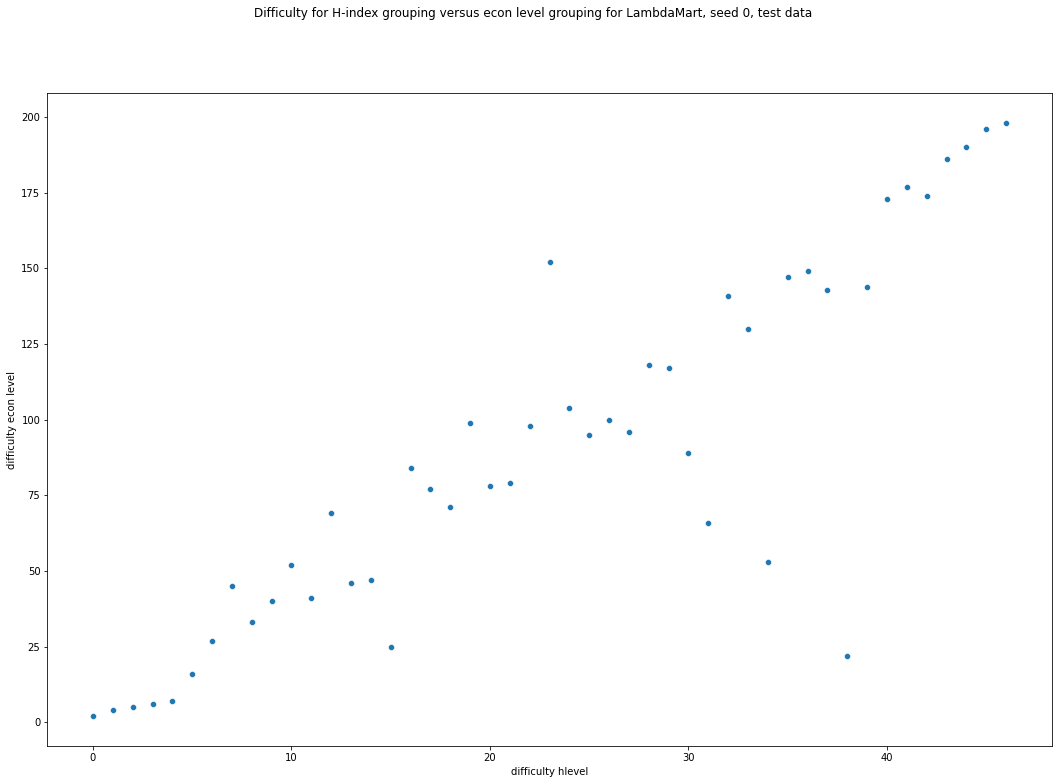

In [56]:
fig, ax = plt.subplots(1,1,figsize=(18,12))

sns.scatterplot(data=edf_m, x='difficulty hlevel', y='difficulty econ level',ax=ax)
fig.suptitle('Difficulty for H-index grouping versus econ level grouping for LambdaMart, seed 0, test data')

We see a clear upward trend in the plot above. This tells us that in general, the DGEE according to the two groupings is similar. We would not expect great differences in the analysis results for different groupings.

In [15]:
edf = edf_m.copy()
edf['difference'] = edf.apply(lambda row: (row.difference_x + row.difference_y)/2, axis=1)
edf['disparity'] = edf.apply(lambda row: (row.disparity_x + row.disparity_y)/2, axis=1)
edf['relevance'] = edf.apply(lambda row: (row.relevance_x + row.relevance_y)/2, axis=1)

edf = edf.sort_values(by='difference')[['qid','difference', 'disparity', 'relevance']]
edf.head()

key,qid,difference,disparity,relevance
0,49868,0.000405,1.885017,1.864012
1,107238,0.000609,1.869202,1.835515
2,3661,0.000743,1.804429,1.778329
3,42519,0.000976,1.890582,1.847635
4,62246,0.001863,1.726863,1.686415


## 1. Behavior on top relevant documents
Can these documents be categorized and distinguished from others? We want to find out which characteristics of a document help the ranker to place it in the correct location.

### Methods

In [16]:
def extract_results_based_on_qid(qid, ranking_df):
    return ranking_df[ranking_df.qid == qid]

def extract_relevances_based_on_qid(qid, relevance_df):
    return relevance_df[relevance_df.qid == qid]

In [17]:
def count_relgrades(relevance_df):
    rel_counts = relevance_df.doc_rel.value_counts()
    rel_count = rel_counts[1]
    nonrel_count = rel_counts[0]
    return rel_count, nonrel_count

def count_relgrades_qid(qid, relevance):
    subrelevance = extract_relevances_based_on_qid(qid, relevance)
    return count_relgrades(subrelevance)


In [18]:
def ranking_to_df(ranking, relevance):
    ranking = ranking[['qid','ranking']].reset_index(drop=True)
    ranking = ranking.explode('ranking')
    ranking['rank'] = ranking.groupby(level=0).cumcount()
    ranking = ranking.reset_index(drop=True)
    ranking = ranking.rename({'ranking':'doc_id'},axis=1)
    merge = pd.merge(ranking,relevance[['qid','doc_id','doc_rel']], on = ['qid', 'doc_id'], how='left')
    merge['rel'] = merge['doc_rel'].apply(lambda row: 'rel' if row == 1 else 'nonrel')
    return merge

In [34]:
rankdf = ranking_to_df(rdf,reldf)
rankdf.head()

,qid,doc_id,rank,doc_rel,rel
0,5438,b2fdee22aa02477292b858fbafcb418932732bce,0,1,rel
1,5438,993db6e50adc33307896403c83ef10399883454f,1,0,nonrel
2,5438,c50a7f1850d1770fe728b8e42200e463ca669896,2,0,nonrel
3,5438,8466964cf0884351c3e1b8444b5d71e64eb69dd6,3,0,nonrel
4,5438,1f1946887c8be228864ee23374bc0b427abf0884,4,0,nonrel


In [20]:
def plot_positions(qid, ranking, relevance):
    data = ranking[ranking.qid == qid]
    data["doc_labels"] = data.apply(lambda row: f"{row['rank']}: {row.doc_id[:4]}...", axis=1,result_type='expand')
    
    fig, ax = plt.subplots(1,1,figsize=(9,6))
    sns.scatterplot(data=data, x='doc_labels', y='rel', hue='rel',ax = ax)
    rel = count_relgrades_qid(qid, relevance)[0]
    ax.axvline(x=rel + 0.5, color='g')
    ax.set_xticks(np.arange(len(data)))
    fig.suptitle(f'Relevance/non-relevant documents for qid {qid}')
    
    
    ax.set_xticklabels(data.doc_labels.to_list(),rotation = -70)
        
    

In [22]:
def count_rel_nonrel_per_rank(rankings_df, relevance_df):
    """rankings_df and relevance_df should already be reduced to the information for a single qid"""
    countdict = {k :{'r':0,'nr':0} for k in range(1,len(rankings_df['ranking'].iloc[0]) + 1)}
    for idx, row in rankings_df.iterrows():
        for i, doc in enumerate(row['ranking']):
            rel = relevance_df[relevance_df.doc_id == doc].doc_rel.iloc[0]
            if rel == 0:
                countdict[i+1]['nr'] = countdict[i+1]['nr'] + 1
            elif rel == 1:
                countdict[i+1]['r'] = countdict[i+1]['r'] + 1
            else:
                raise ValueError
    return countdict
            

In [24]:
def rel_nonrel_per_rank_counts_to_sns_df(countdict):
    unpacked = [record for reclist in [[{**{'rank':k},**{'relkind':k2,'count':v2}} for k2,v2 in v.items()] for k,v in countdict.items()] for record in reclist]
    return pd.DataFrame(unpacked)

### Computation
1. What percentage of the top positions was occupied by relevant documents?  
    a. Which relevant documents were most often in a top position? 
        - More specifically: which relevant documents were more often in a top position than any other document for the ranking?    
            - Which relevant documents were among the top 75% of the documents in the top positions, frequency-wise.
2. What was their predicted relevance score?  
3. What was their author?  
    - Did their author write more of the documents in the ranking?

#### Percentage of relevant documents

In [25]:
relfrac = []
for q in edf.head(10).qid.to_list():
    subrdf = extract_results_based_on_qid(q, rdf)
    subreldf = extract_relevances_based_on_qid(q, reldf)
    
    num_rel_docs, num_nonrel_docs = count_relgrades(subreldf)
    
    rel_nonrel_counts = count_rel_nonrel_per_rank(subrdf, subreldf)
    rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)
    
    # doc_per_rank_counts = count_doc_occurrence_per_rank(subrdf)
    # rank_occurrence_df = doc_occurrence_per_rank_to_sns_df(doc_per_rank_counts, subreldf)
    
    top_with_rel_frac = round(rel_nonrel_df[(rel_nonrel_df['rank'] <= num_rel_docs) & (rel_nonrel_df['relkind'] == 'r')]['count'].sum() / (num_rel_docs) * 100,2)
    relfrac.append(top_with_rel_frac)
    print(q, "\t", top_with_rel_frac)

49868 	 100.0
107238 	 66.67
3661 	 100.0
42519 	 66.67
62246 	 100.0
70381 	 50.0
53737 	 66.67
73836 	 66.67
23837 	 40.0
90609 	 66.67


In [26]:
np.array(relfrac).mean()

72.33500000000001

In [27]:
relfrac = []
for q in edf.tail(10).iloc[::-1].qid.to_list():
    subrdf = extract_results_based_on_qid(q, rdf)
    subreldf = extract_relevances_based_on_qid(q, reldf)
    
    num_rel_docs, num_nonrel_docs = count_relgrades(subreldf)
    
    rel_nonrel_counts = count_rel_nonrel_per_rank(subrdf, subreldf)
    rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)
    
    # doc_per_rank_counts = count_doc_occurrence_per_rank(subrdf)
    # rank_occurrence_df = doc_occurrence_per_rank_to_sns_df(doc_per_rank_counts, subreldf)
    
    top_with_rel_frac = round(rel_nonrel_df[(rel_nonrel_df['rank'] <= num_rel_docs) & (rel_nonrel_df['relkind'] == 'r')]['count'].sum() / (num_rel_docs) * 100,2)
    relfrac.append(top_with_rel_frac)
    print(q, "\t", top_with_rel_frac)

84087 	 0.0
47984 	 0.0
99619 	 0.0
28270 	 0.0
71096 	 0.0
9455 	 44.44
439 	 14.29
66896 	 33.33
9536 	 25.0
21984 	 0.0


In [28]:
np.array(relfrac).mean()

11.706

### Visualization

For each rank, we show how often it is occupied by a relevant document. We show this for the top and bottom 10 queries so we can determine both what documents are placed in top positions on easy queries and which on difficult queries.

We also show which documents are found most often in the top positions for the top and bottom 10 queries.

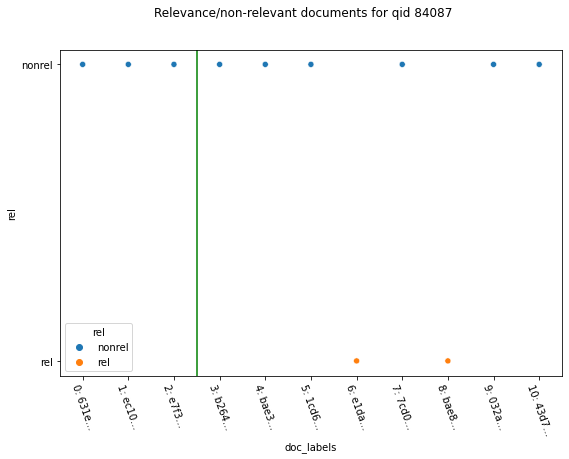

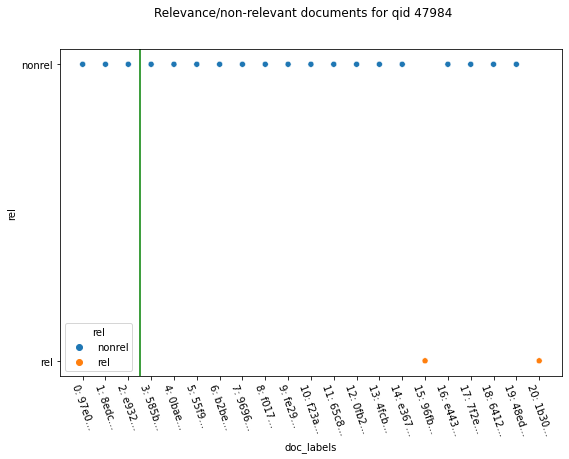

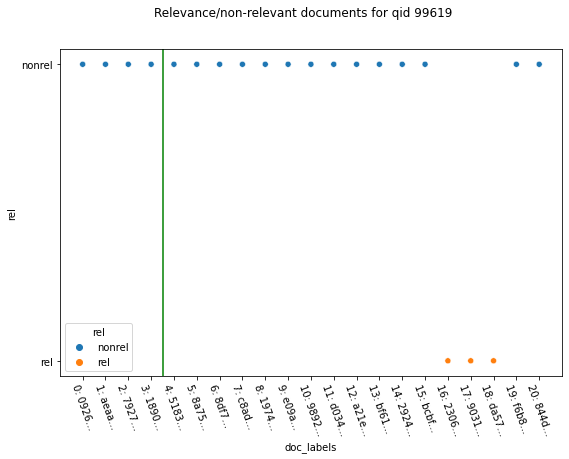

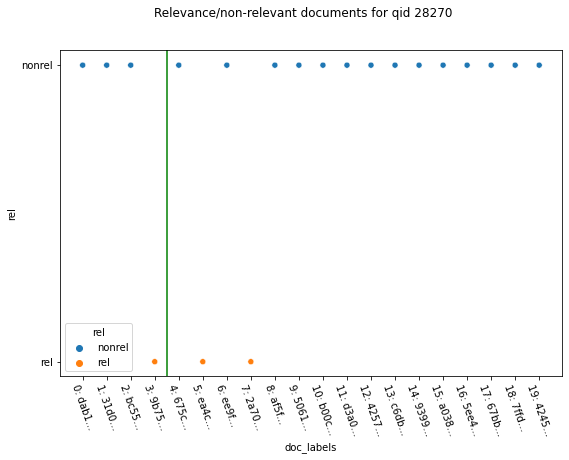

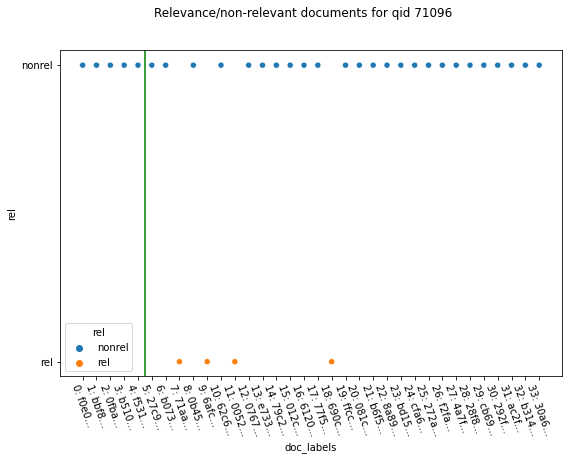

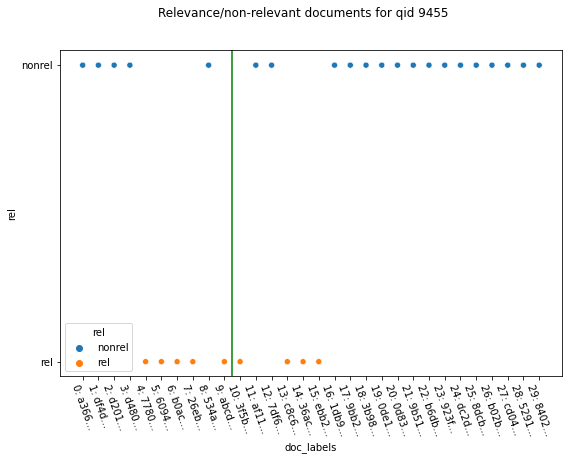

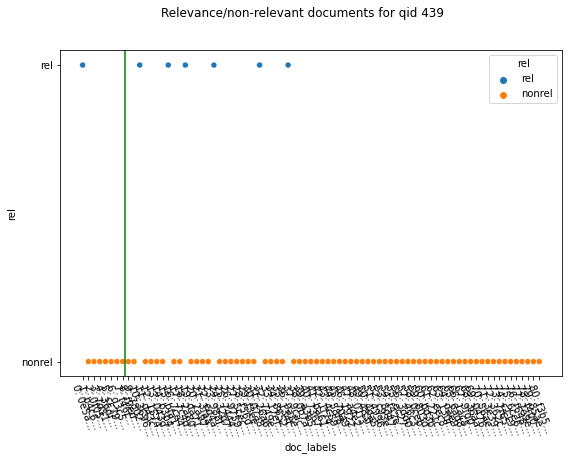

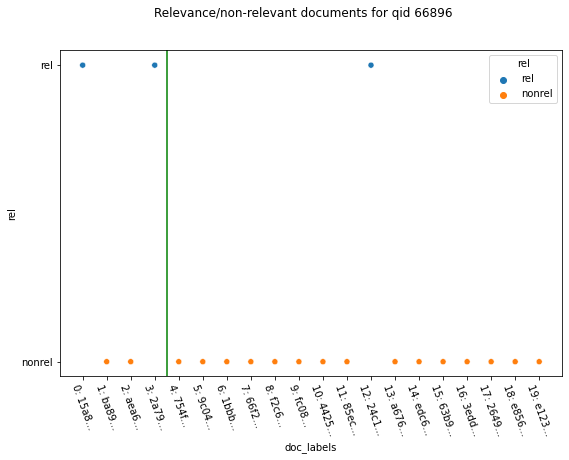

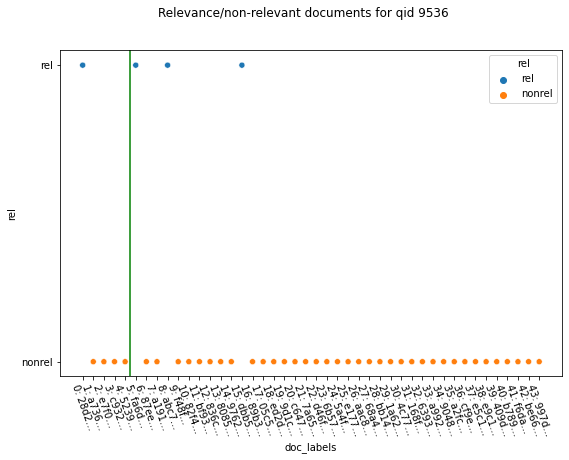

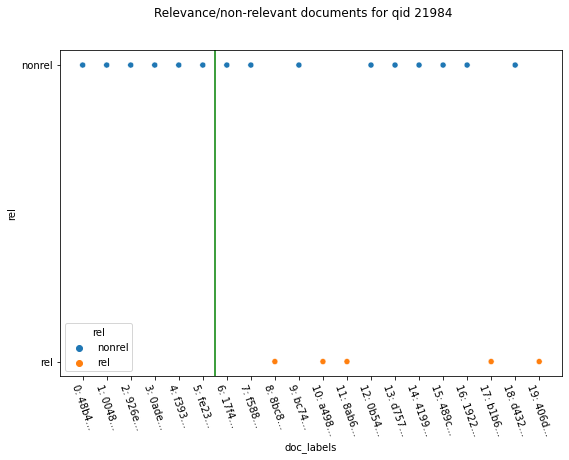

In [30]:
for q in edf.tail(10).iloc[::-1].qid.to_list():
    plot_positions(q,rankdf,reldf)

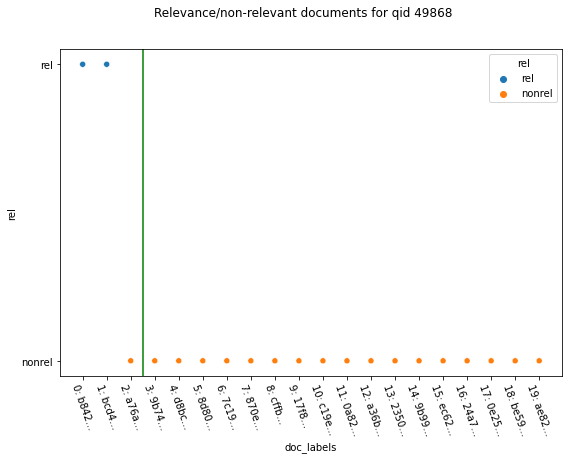

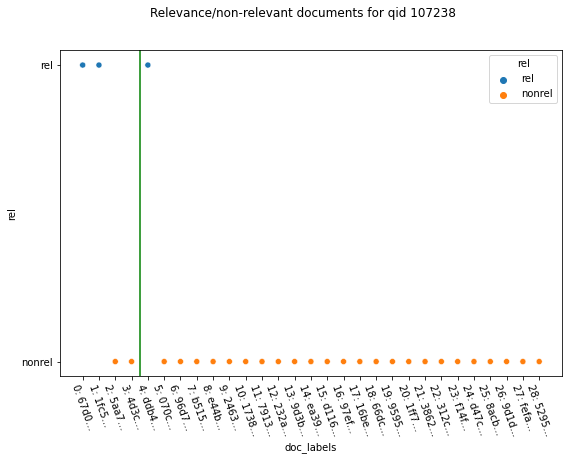

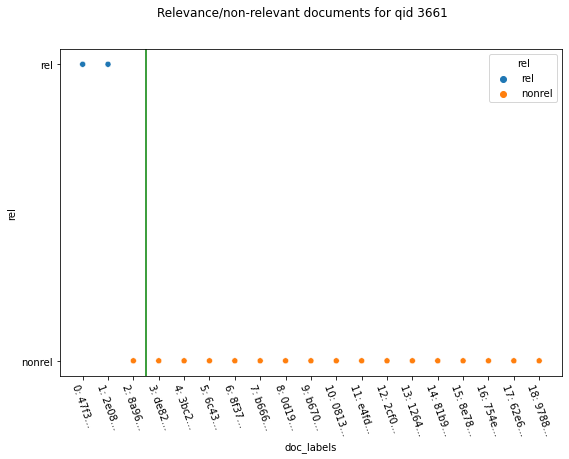

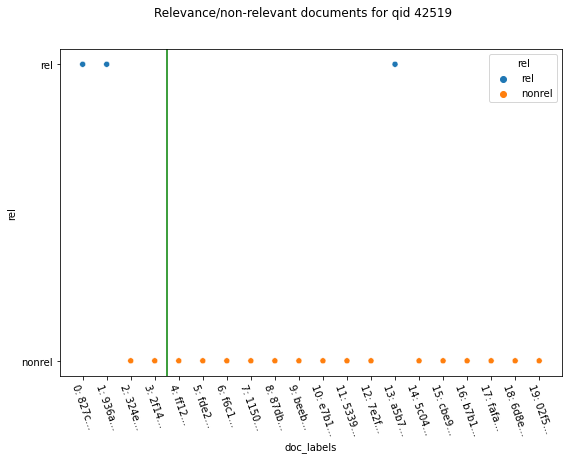

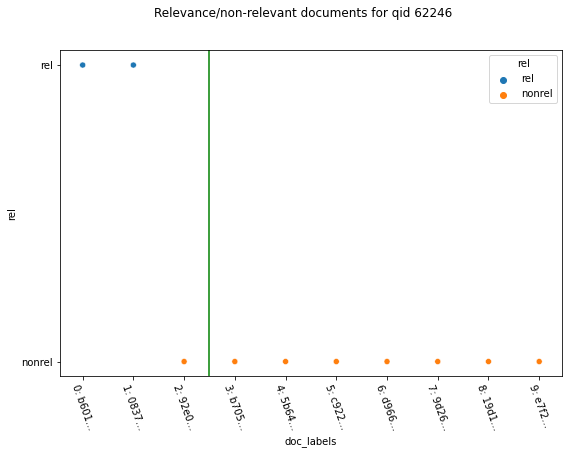

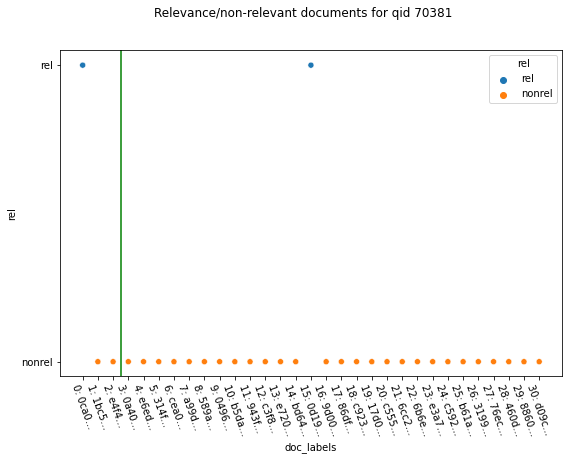

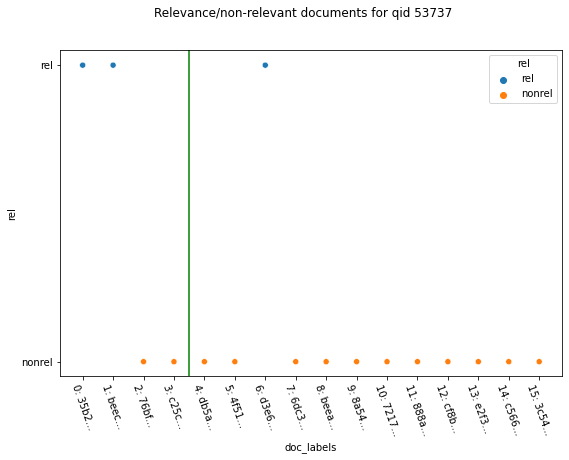

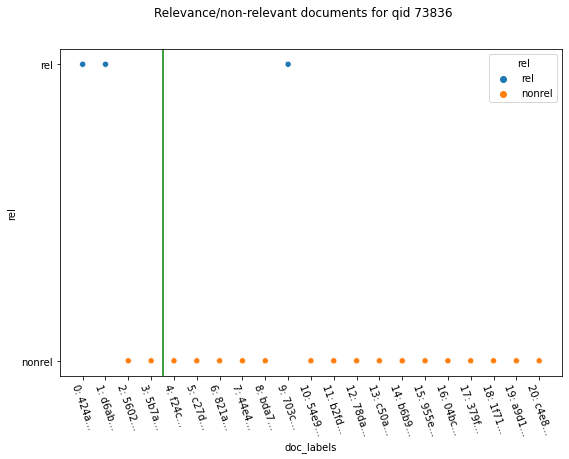

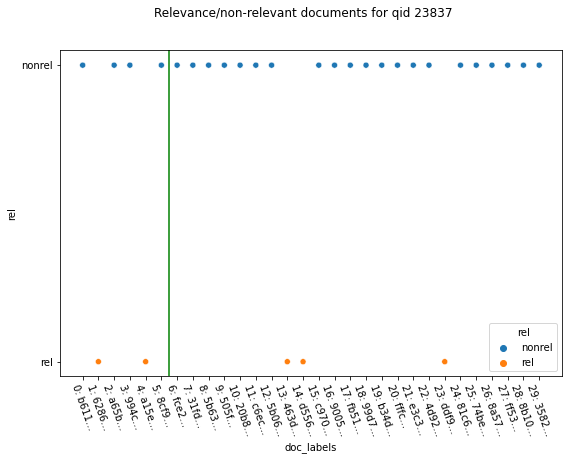

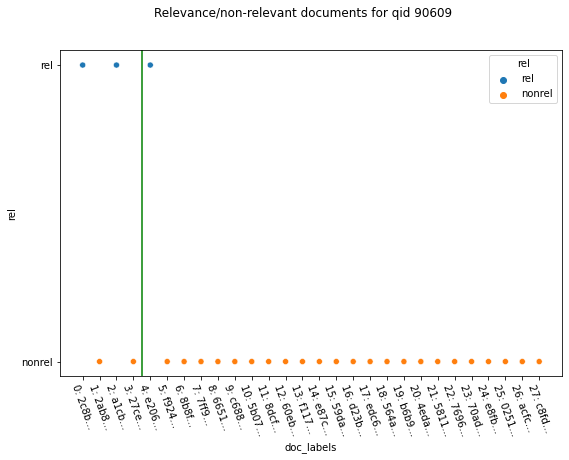

In [31]:
for q in edf.head(10).qid.to_list():
    plot_positions(q,rankdf,reldf)

## 2. Behavior on top non-relevant documents  
Can these documents be categorized and distinguished from other documents?

### Computation
1. What percentage of the top positions was occupied by relevant documents?  
    a. Which relevant documents were most often in a top position? 
        - More specifically: which relevant documents were more often in a top position than any other document for the ranking?    
            - Which relevant documents were among the top 75% of the documents in the top positions, frequency-wise.
2. What was their predicted relevance score?  
3. What was their author?  
    - Did their author write more of the documents in the ranking?

#### Percentage of non-relevant documents

In [35]:
fraclist = []
for q in edf.head(10).qid.to_list():
    subrdf = extract_results_based_on_qid(q, rdf)
    subreldf = extract_relevances_based_on_qid(q, reldf)
    
    num_rel_docs, num_nonrel_docs = count_relgrades(subreldf)
    
    rel_nonrel_counts = count_rel_nonrel_per_rank(subrdf, subreldf)
    rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)
    
    # doc_per_rank_counts = count_doc_occurrence_per_rank(subrdf)
    # rank_occurrence_df = doc_occurrence_per_rank_to_sns_df(doc_per_rank_counts, subreldf)
    
    top_with_rel_frac = round(rel_nonrel_df[(rel_nonrel_df['rank'] <= num_rel_docs) & (rel_nonrel_df['relkind'] == 'nr')]['count'].sum() / ( num_rel_docs) * 100,2)
    fraclist.append(top_with_rel_frac)
    print(q, "\t", top_with_rel_frac)

49868 	 0.0
107238 	 33.33
3661 	 0.0
42519 	 33.33
62246 	 0.0
70381 	 50.0
53737 	 33.33
73836 	 33.33
23837 	 60.0
90609 	 33.33


In [36]:
np.array(fraclist).mean()

27.665

In [37]:
fraclist = []
for q in edf.tail(10).iloc[::-1].qid.to_list():
    subrdf = extract_results_based_on_qid(q, rdf)
    subreldf = extract_relevances_based_on_qid(q, reldf)
    
    num_rel_docs, num_nonrel_docs = count_relgrades(subreldf)
    
    rel_nonrel_counts = count_rel_nonrel_per_rank(subrdf, subreldf)
    rel_nonrel_df = rel_nonrel_per_rank_counts_to_sns_df(rel_nonrel_counts)
    
    # doc_per_rank_counts = count_doc_occurrence_per_rank(subrdf)
    # rank_occurrence_df = doc_occurrence_per_rank_to_sns_df(doc_per_rank_counts, subreldf)
    
    top_with_rel_frac = round(rel_nonrel_df[(rel_nonrel_df['rank'] <= num_rel_docs) & (rel_nonrel_df['relkind'] == 'nr')]['count'].sum() / (150 * num_rel_docs) * 100,2)
    fraclist.append(top_with_rel_frac)
    print(q, "\t", top_with_rel_frac)

84087 	 0.67
47984 	 0.67
99619 	 0.67
28270 	 0.67
71096 	 0.67
9455 	 0.37
439 	 0.57
66896 	 0.44
9536 	 0.5
21984 	 0.67


In [38]:
np.array(fraclist).mean()

0.5900000000000001

### Visualization

For each rank, we show how often it is occupied by a relevant document. We show this for the top and bottom 10 queries so we can determine both what documents are placed in top positions on easy queries and which on difficult queries.

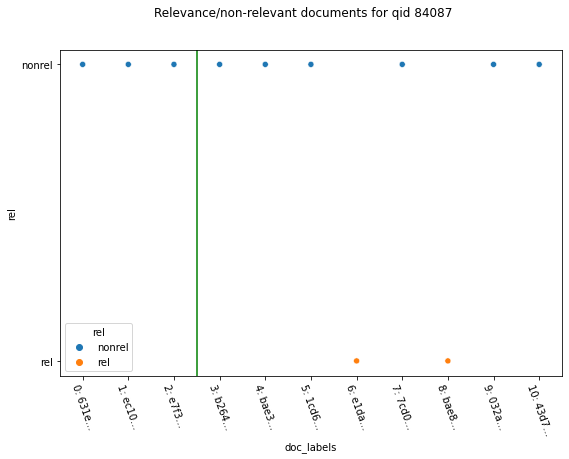

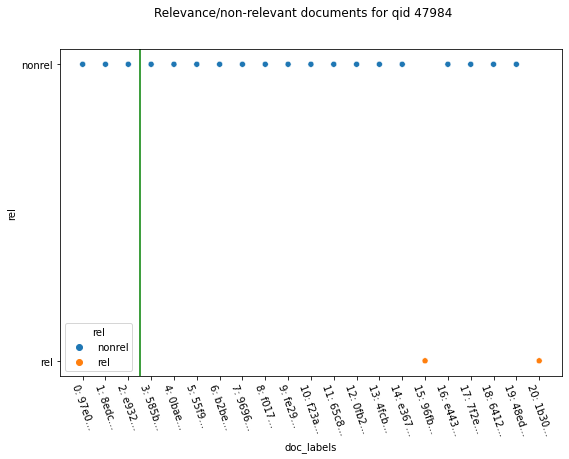

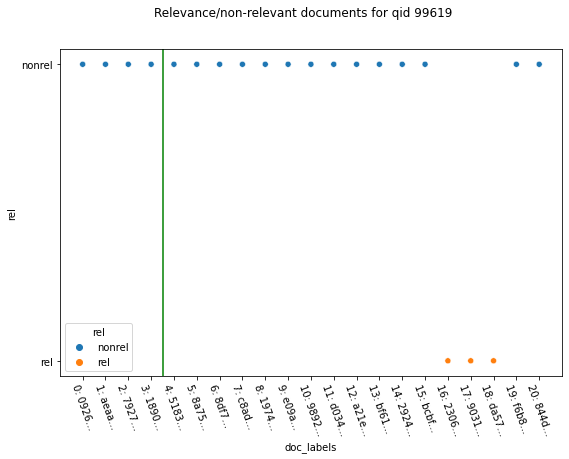

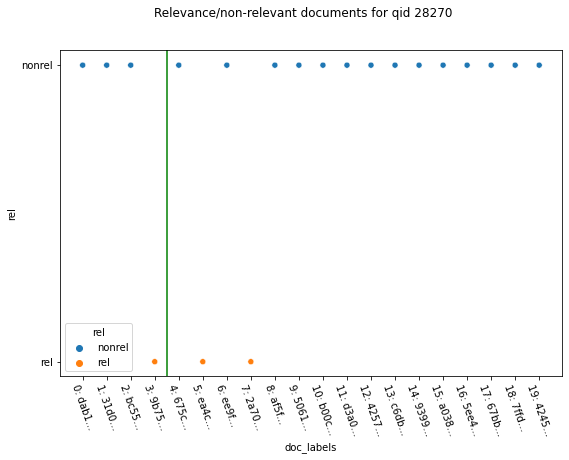

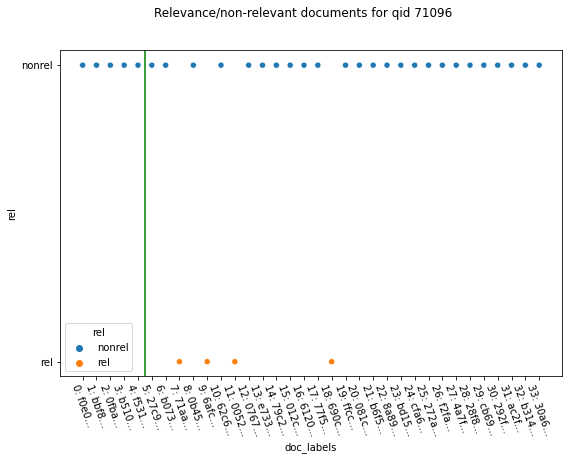

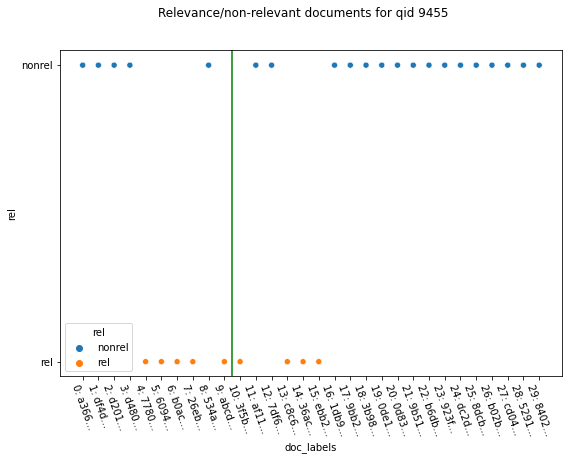

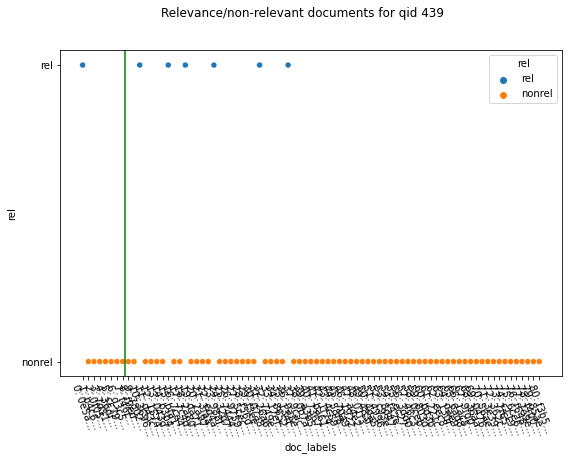

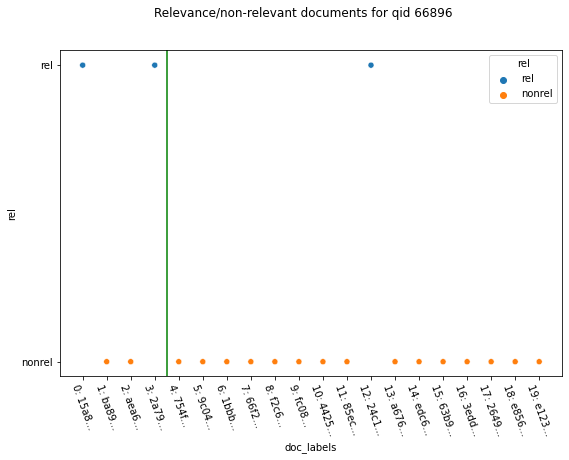

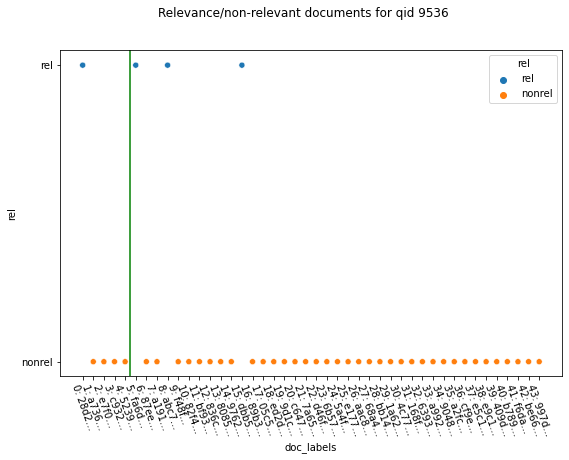

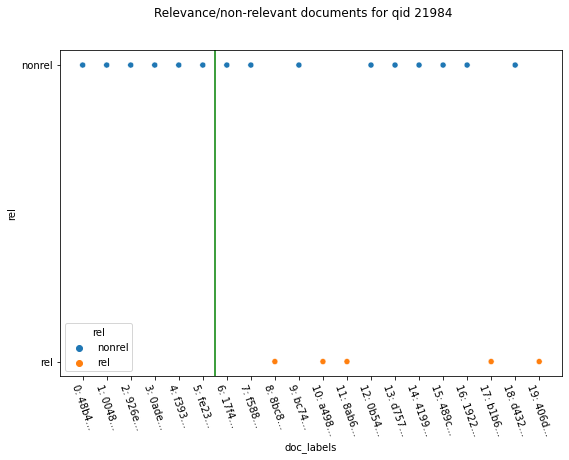

In [39]:
for q in edf.tail(10).iloc[::-1].qid.to_list():
    plot_positions(q,rankdf,reldf)

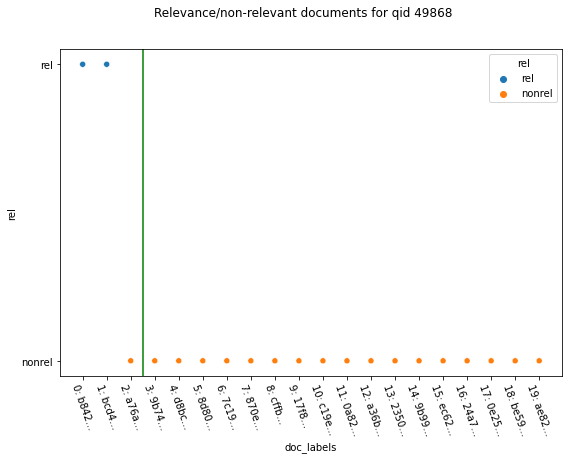

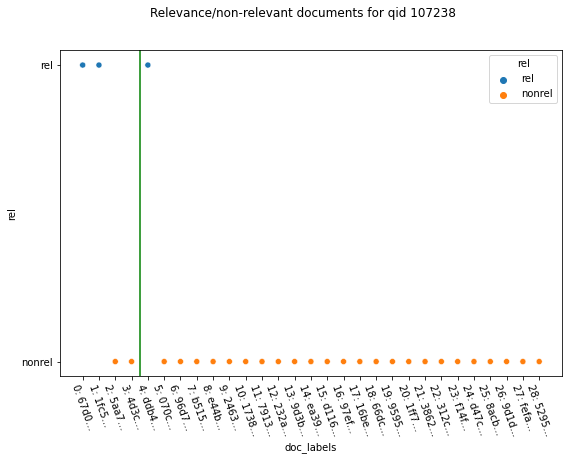

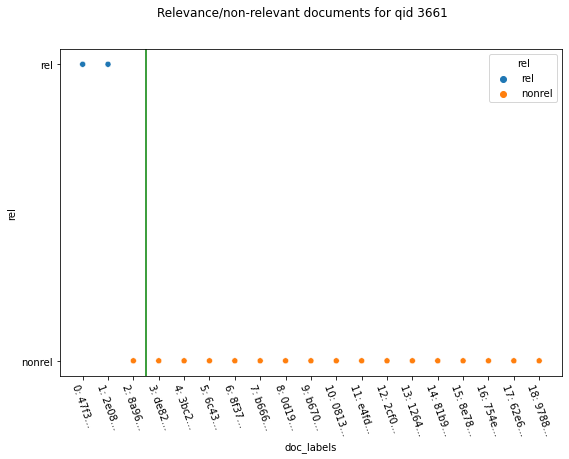

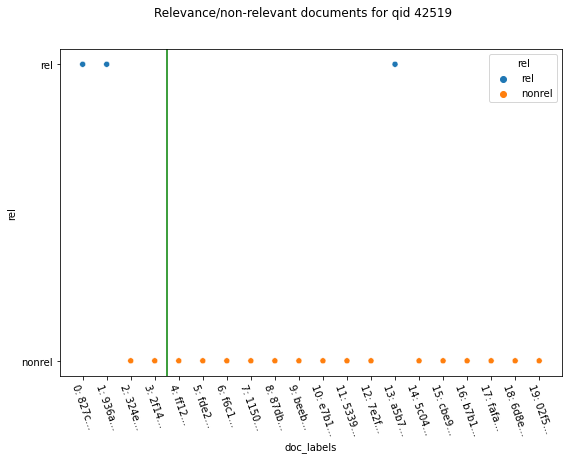

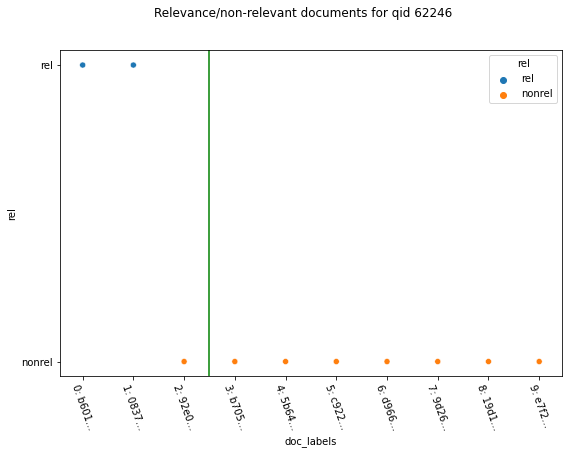

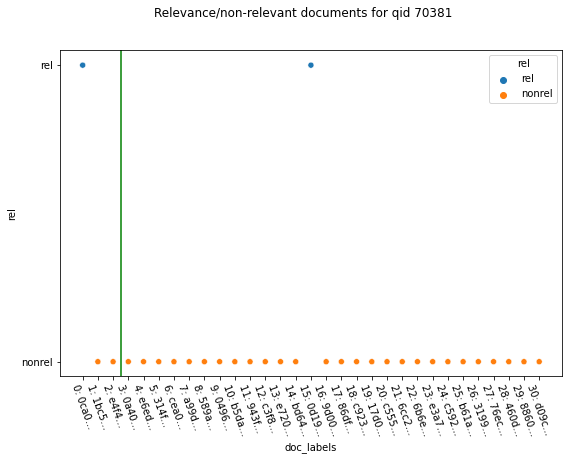

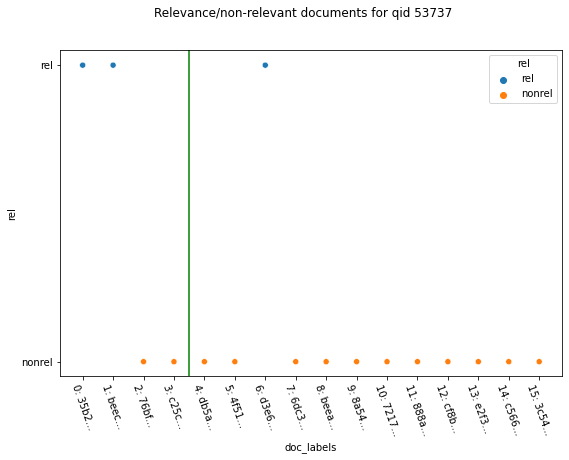

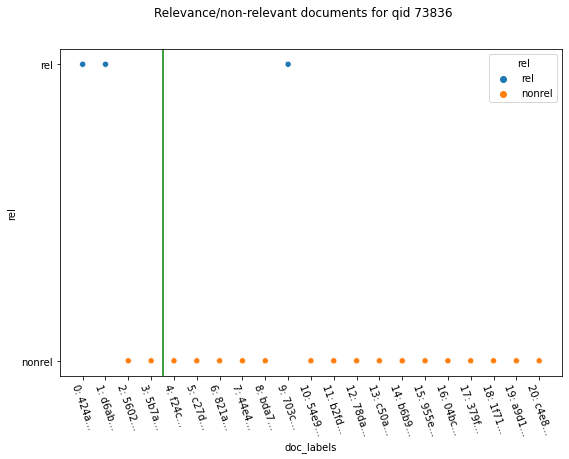

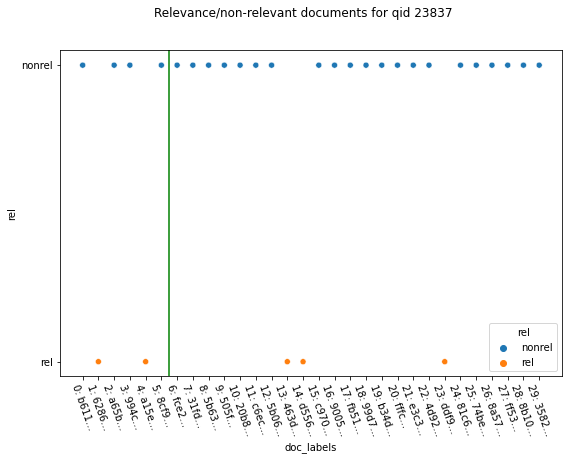

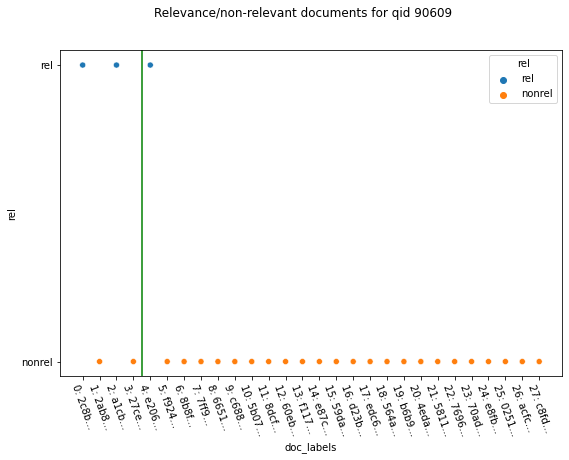

In [41]:
for q in edf.head(10).qid.to_list():
    plot_positions(q,rankdf,reldf)

## 3. Which relevant documents do not appear in top positions?

## 4. How does the distribution of disparity, relevance, and constant terms change with increasing query difficulty, as measured by DGEE?

In [42]:
edf = edf.sort_values(by='difference')
edf.head()

key,qid,difference,disparity,relevance
0,49868,0.000405,1.885017,1.864012
1,107238,0.000609,1.869202,1.835515
2,3661,0.000743,1.804429,1.778329
3,42519,0.000976,1.890582,1.847635
4,62246,0.001863,1.726863,1.686415


In [46]:
edf < -- why only 46 queries?

key,qid,difference,disparity,relevance
0,49868,0.000405,1.885017,1.864012
1,107238,0.000609,1.869202,1.835515
2,3661,0.000743,1.804429,1.778329
3,42519,0.000976,1.890582,1.847635
4,62246,0.001863,1.726863,1.686415
5,70381,0.015623,2.249977,2.062490
6,53737,0.065139,1.262318,1.095192
8,73836,0.087002,1.320504,1.114478
7,23837,0.105535,1.548841,1.326230
15,90609,0.108007,1.207505,1.036389


In [45]:
dif_disp_rel = edf.reset_index(drop=True).reset_index().rename({'index':'difficulty'}, axis=1)
disp = dif_disp_rel[["difficulty","disparity"]].rename({'disparity':'value'}, axis=1)
relp = dif_disp_rel[["difficulty","relevance"]].rename({'relevance':'value'}, axis=1)
concatenated = pd.concat([disp.assign(metric='disparity'), relp.assign(metric='relevance')])
concatenated


key,difficulty,value,metric
0,0,1.885017,disparity
1,1,1.869202,disparity
2,2,1.804429,disparity
3,3,1.890582,disparity
4,4,1.726863,disparity
5,5,2.249977,disparity
6,6,1.262318,disparity
7,7,1.320504,disparity
8,8,1.548841,disparity
9,9,1.207505,disparity


Text(0.5, 0.98, 'Relevance and disparity versus difficulty')

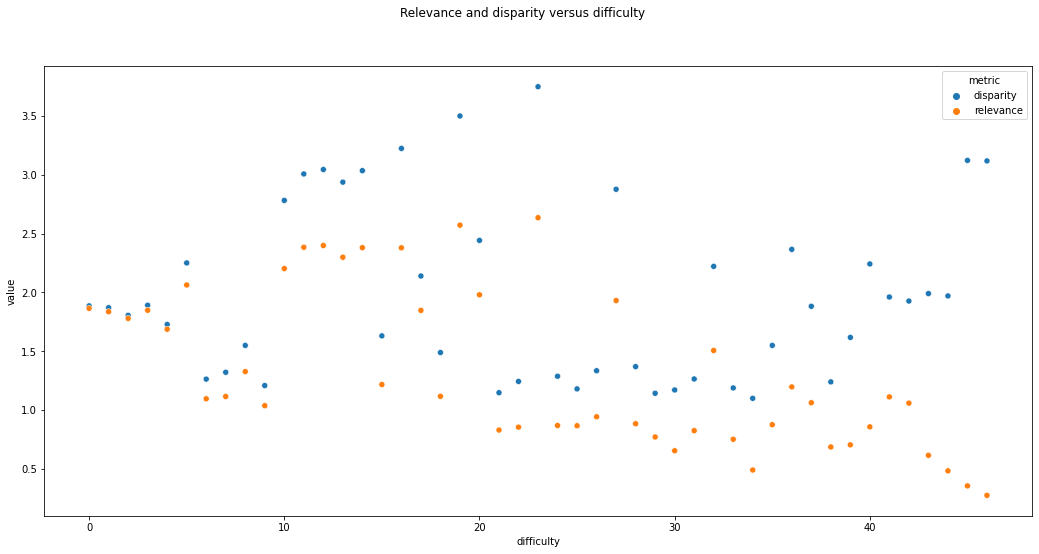

In [44]:
fig, ax = plt.subplots(1,1,figsize = (17.7,8.27))
# ax2 = ax.twinx()

pi = iter(sns.color_palette())
f = next(pi)
s = next(pi)

sns.scatterplot(data=concatenated, x='difficulty', y='value',hue='metric',ax=ax)



fig.suptitle('Relevance and disparity versus difficulty')

# Bibliography

[1] Buckley, ‘Reliable Information Access Final Workshop Report’.